**This notebook provide the best practices to consume covid-lake API.**

In [2]:
# General Import

import pandas as pd
import numpy as np
import re
import seaborn as sns

#!pip install scipy
import scipy
pearsonr = scipy.stats.pearsonr

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline

In [3]:
#obitos = pd.read_csv (r'https://raw.githubusercontent.com/helenam42/COVID_Lake/main/obito_cartorio.csv')

In [4]:
%run /home/ubuntu/notebooks/covid-prj01-data-analysis/[UTILS]/dremio-access-new.py

dremio = DremioQueryMakerJDBC()
index = dremio.getIndex()
#list(index['TABLE_NAME'].unique())

In [5]:
index_table = index['TABLE_NAME'].loc[index['TABLE_NAME'] == 'obitos_cartorio_2019_2020'].index[0]
index_table

46

In [6]:
obitos = dremio.getTable(index_table)
obitos.head()

,ano,uf,tipo_doenca,local_obito,faixa_etaria(anos),sexo,total
0,2019,AC,outras,domicilio,0 - 9,F,8
1,2019,AC,outras,domicilio,0 - 9,M,15
2,2019,AC,outras,hospital,0 - 9,F,29
3,2019,AC,outras,hospital,0 - 9,M,56
4,2019,AC,outras,ignorado,0 - 9,M,1


In [7]:
obitos.shape

(26298, 7)

In [8]:
# Tipos de doenças
list(obitos['tipo_doenca'].unique())

['outras',
 'indeterminada',
 'insuficiencia_respiratoria',
 'pneumonia',
 'septicemia',
 'srag',
 'covid']

In [41]:
# Faixa etária
list(obitos['faixa_etaria(anos)'].unique())

['0 - 9',
 0,
 '20 - 29',
 '30 - 39',
 '40 - 49',
 '50 - 59',
 '60 - 69',
 '70 - 79',
 '80 - 89',
 '90 - 99',
 '> 100',
 'N/I']

## exploreEntity

Presents an overview of the tables existing in the covid-lake.

URL: http://23.20.157.201/api/exploreEntity

*Each Table represents a CDM (Common Data Model) because it encompesses a set of dataset collected from different sources and mapped following a standard enitity.*

### Let's play with Data :)

- **Analyzing obitos dataset**

Checking all columns

In [9]:
all_columns = obitos.columns.values.tolist()
print('Total columns:', len(all_columns))

Total columns: 7


In [10]:
all_columns

['ano',
 'uf',
 'tipo_doenca',
 'local_obito',
 'faixa_etaria(anos)',
 'sexo',
 'total']

Verifying all NAs

In [11]:
# count NAs per column
obitos.isna().sum()

ano                      0
uf                       0
tipo_doenca              0
local_obito              0
faixa_etaria(anos)    1393
sexo                     0
total                    0
dtype: int64

Replacing all NAs

In [12]:
# remove columns full of NAs
#casos_full.dropna(inplace=True)
#casos_full.head()

In [13]:
obitos = obitos.fillna(0)

Verifying the duplicated columns

In [14]:
# drop duplicates
obitos.drop_duplicates() 
# no duplicates

,ano,uf,tipo_doenca,local_obito,faixa_etaria(anos),sexo,total
0,2019,AC,outras,domicilio,0 - 9,F,8
1,2019,AC,outras,domicilio,0 - 9,M,15
2,2019,AC,outras,hospital,0 - 9,F,29
3,2019,AC,outras,hospital,0 - 9,M,56
4,2019,AC,outras,ignorado,0 - 9,M,1
...,...,...,...,...,...,...,...
26293,2020,TO,indeterminada,hospital,N/I,F,3
26294,2020,TO,indeterminada,hospital,N/I,M,2
26295,2020,TO,insuficiencia_respiratoria,hospital,N/I,F,1
26296,2020,TO,pneumonia,hospital,N/I,F,1


In [15]:
obitos.shape

(26298, 7)

Describe the dataset

In [16]:
obitos.describe()

,total
count,26298.000000
mean,84.663434
std,390.039069
min,1.000000
25%,2.000000
50%,6.000000
75%,32.000000
max,12263.000000


Frequency of each state

In [17]:
# array with each count    
counts = np.unique(obitos['uf'], return_counts=True)

# dataframe
state_count = pd.DataFrame({'uf': counts[0], 'freq': counts[1]})
state_count.sort_values(by=['freq'], inplace=True,ascending=False)
state_count.head()

,uf,freq
25,SP,1718
10,MG,1463
5,CE,1291
4,BA,1288
15,PE,1271


In [23]:
# array with each count    
counts = np.unique(obitos['sexo'], return_counts=True)

# dataframe
state_count = pd.DataFrame({'sexo': counts[0], 'freq': counts[1]})
state_count.sort_values(by=['freq'], inplace=True,ascending=False)
state_count.head()

,sexo,freq
3,M,13406
1,F,12182
2,I,707
0,,3


Descriptive analysis

## Graphs

In [24]:
df = obitos

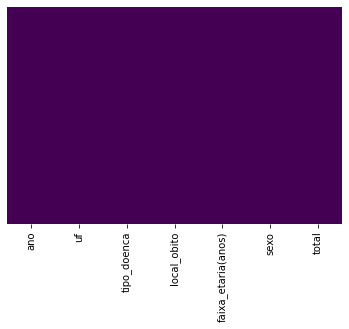

In [25]:
# Missing values
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### Total cases distribution


[Text(0.5, 0, '')]

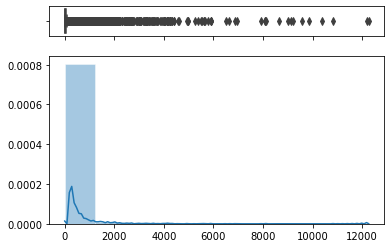

In [30]:
confirmed_cases = obitos['total'].values

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.set_style("darkgrid")
sns.boxplot(confirmed_cases, ax=ax_box)
sns.distplot(confirmed_cases, bins=10, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Analyzing state by state

In [32]:
df = obitos

In [33]:
df.columns

Index(['ano', 'uf', 'tipo_doenca', 'local_obito', 'faixa_etaria(anos)', 'sexo',
       'total'],
      dtype='object')

In [36]:
# Filtering SP value
SP_boolean = df.uf == 'SP'
SP_boolean

df_sp = df[SP_boolean]
df_sp = df_sp.sort_values('ano')
df_sp = df_sp.dropna(subset=['uf'])

df_sp.shape

(1718, 7)

In [56]:
# Filtering MG value
MG_boolean = df.uf == 'MG'

df_mg = df[MG_boolean]
df_mg = df_mg.sort_values('ano')
df_mg = df_mg.dropna(subset=['uf'])

mg_shape = df_mg.shape

# srag MG
srag = df_mg.tipo_doenca == 'srag'

df_mg_srag = df_mg[srag]
df_mg_srag = df_mg_srag.sort_values('ano')
df_mg_srag = df_mg_srag.dropna(subset=['tipo_doenca'])

srag_shape = df_mg_srag.shape

# pneumonia MG
pneumonia = df_mg.tipo_doenca == 'pneumonia'

df_mg_pneumonia = df_mg[pneumonia]
df_mg_pneumonia = df_mg_pneumonia.sort_values('ano')
df_mg_pneumonia = df_mg_pneumonia.dropna(subset=['tipo_doenca'])

pneumonia_shape = df_mg_pneumonia.shape

# covid MG
covid = df_mg.tipo_doenca == 'covid'

df_mg_covid = df_mg[covid]
df_mg_covid = df_mg_covid.sort_values('ano')
df_mg_covid = df_mg_covid.dropna(subset=['tipo_doenca'])

covid_shape = df_mg_covid.shape
df_mg_covid.head()

,ano,uf,tipo_doenca,local_obito,faixa_etaria(anos),sexo,total
22404,2020,MG,covid,domicilio,80 - 89,F,36
17764,2020,MG,covid,domicilio,50 - 59,F,8
19269,2020,MG,covid,outros_servicos_saude,60 - 69,F,32
13435,2020,MG,covid,outro,0,M,1
13434,2020,MG,covid,hospital,0,M,15


In [57]:
s = sum(df_mg_covid.total)
print (s)

9907


In [55]:
print(mg_shape)
print(srag_shape)
print(pneumonia_shape)
print(covid_shape)

(1463, 7)
(110, 7)
(235, 7)
(97, 7)


In [ ]:
srag = 
pneumonia = 
covid = 